# Hyper parameters

In [369]:
DAYS_FUTURE = 50
DAYS_PAST = 50

HP_UNITS = 200
HP_LAYERS = 3

TRAIN_START = "2015-01-01"
TRAIN_END = "2020-01-01"

TEST_START = "2020-01-01"
TEST_END = "2021-01-01"

HP_DROPOUT = 0.4
HP_LR = 0.001
HP_BATCH_SIZE = 32
HP_EPOCHS = 350

# labels = ['next1', 'next2', 'next3']
labels = ['next1']
SPREAD = 0.00000

INIT_DEPOSIT = 1000


In [370]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline


# Get Data

In [371]:
import quandl as q 

In [372]:
q.ApiConfig.api_key = '11sy5SMsFERx_YypjsMi'

In [373]:
data = q.get('BITFINEX/BTCUSD') 

In [374]:
data

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2014-04-15,513.900000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774
2014-04-16,547.000000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705
2014-04-17,538.500000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819
2014-04-18,509.000000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243
2014-04-19,513.989900,473.83,505.01065,507.499900,502.5313,507.49,8963.618369
...,...,...,...,...,...,...,...
2021-10-28,62444.000000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417
2021-10-29,62980.000000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450
2021-10-30,62409.000000,60755.00,61407.50000,61408.000000,61407.0000,61408.00,2185.606697


<AxesSubplot:xlabel='Date'>

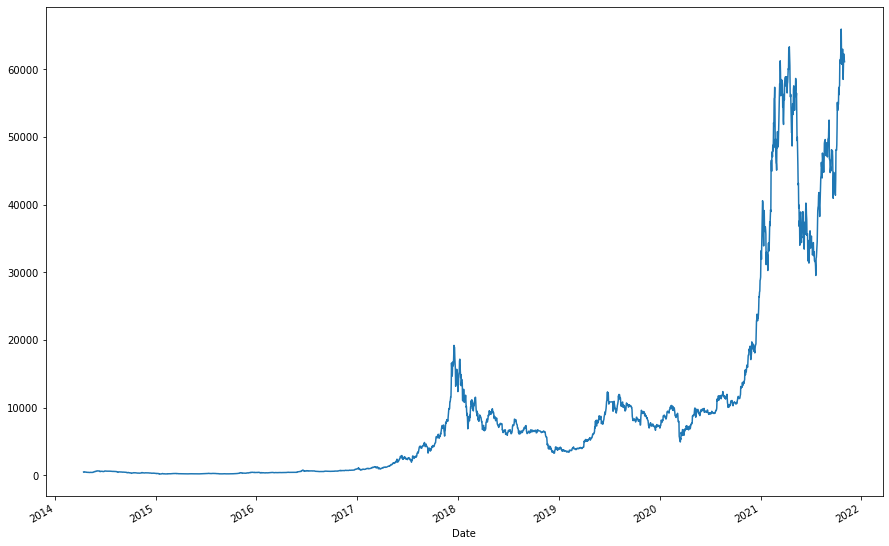

In [375]:
# show candles
data['Last'].plot(figsize=(15, 10))


# Create features

In [376]:
for i in range(1, DAYS_PAST):
    data['prev' + str(i)] = np.log(data['Last'] / data['Last'].shift(i))


In [377]:
for i in range(1, DAYS_FUTURE):
    data['next' + str(i)] = np.log(data['Last'] / data['Last'].shift(-i))


In [378]:
data

,High,Low,Mid,Last,Bid,Ask,Volume,prev1,prev2,prev3,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-15,513.900000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774,NaN,NaN,NaN,...,-0.133630,-0.126886,-0.125419,-0.213369,-0.213193,-0.246241,-0.275153,-0.244692,-0.271764,-0.256253
2014-04-16,547.000000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705,0.063300,NaN,NaN,...,-0.063585,-0.062119,-0.150069,-0.149893,-0.182941,-0.211853,-0.181392,-0.208464,-0.192953,-0.199369
2014-04-17,538.500000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819,-0.057377,0.005923,NaN,...,-0.119496,-0.207446,-0.207270,-0.240318,-0.269230,-0.238769,-0.265841,-0.250330,-0.256746,-0.258480
2014-04-18,509.000000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243,-0.050983,-0.108360,-0.045060,...,-0.258429,-0.258253,-0.291301,-0.320213,-0.289751,-0.316823,-0.301312,-0.307728,-0.309463,-0.298227
2014-04-19,513.989900,473.83,505.01065,507.499900,502.5313,507.49,8963.618369,0.049998,-0.000985,-0.058362,...,-0.208255,-0.241303,-0.270215,-0.239754,-0.266826,-0.251315,-0.257731,-0.259465,-0.248229,-0.258401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-28,62444.000000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417,0.034978,0.007653,-0.038649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-29,62980.000000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450,0.027586,0.062564,0.035239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-30,62409.000000,60755.00,61407.50000,61408.000000,61407.0000,61408.00,2185.606697,-0.014341,0.013245,0.048223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Model create

In [379]:
import tensorflow as tf


In [380]:
# create an MLP model
def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HP_UNITS,
              activation='relu', input_shape=input_shape))
    for a in range(HP_LAYERS):
        model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu'))
        if a != HP_LAYERS:
            model.add(tf.keras.layers.Dropout(HP_DROPOUT))

    model.add(tf.keras.layers.Dense(units=output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        HP_LR), metrics=["accuracy"])
    return model


# Split to train set and test set

In [381]:
X_train = data.loc[(data.index >= TRAIN_START) &
                   (data.index <= TRAIN_END)]
X_test = data.loc[(data.index >= TEST_START) &
                  (data.index <= TEST_END)]


In [382]:
X_test.head()

,High,Low,Mid,Last,Bid,Ask,Volume,prev1,prev2,prev3,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7285.1,7185.4,7213.05,7213.1,7213.0,7213.1,2045.343527,0.000319,-0.006701,-0.027728,...,-0.314705,-0.351476,-0.359057,-0.346881,-0.358185,-0.315625,-0.325686,-0.294679,-0.345261,-0.287290
2020-01-02,7225.8,6963.0,6989.45,6989.5,6989.4,6989.5,4848.085330,-0.031490,-0.031171,-0.038191,...,-0.382966,-0.390546,-0.378371,-0.389675,-0.347115,-0.357176,-0.326169,-0.376750,-0.318780,-0.318225
2020-01-03,7444.9,6909.3,7356.95,7356.9,7356.9,7357.0,6653.414357,0.051230,0.019740,0.020059,...,-0.339317,-0.327141,-0.338445,-0.295885,-0.305946,-0.274940,-0.325521,-0.267551,-0.266995,-0.276487
2020-01-04,7422.0,7297.3,7373.05,7373.0,7373.0,7373.1,4264.090728,0.002186,0.053416,0.021926,...,-0.324955,-0.336259,-0.293699,-0.303760,-0.272754,-0.323335,-0.265364,-0.264809,-0.274301,-0.270241
2020-01-05,7509.9,7315.8,7346.65,7344.9,7346.6,7346.7,4415.509410,-0.003818,-0.001632,0.049597,...,-0.340078,-0.297518,-0.307578,-0.276572,-0.327153,-0.269183,-0.268628,-0.278120,-0.274060,-0.306857


In [383]:

y_train = X_train[labels].to_numpy()  # X - source, y - target
y_test = X_test[labels].to_numpy()


In [384]:
columns = []
for i in range(1, DAYS_PAST):
    columns.append('prev' + str(i))


In [385]:
X_train = X_train[columns].to_numpy()
X_test_times = X_test.index
X_test_price = X_test['Last'].to_numpy()
X_test = X_test[columns].to_numpy()


In [386]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train), y_train))
train_ds = train_ds.take(len(X_train))
test_ds = tf.data.Dataset.from_tensor_slices(((X_test), y_test))
test_ds = test_ds.take(len(X_test))
train_ds = train_ds.batch(HP_BATCH_SIZE, False).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(len(X_test), False).prefetch(tf.data.AUTOTUNE)


In [387]:
model = create_model(X_test.shape, len(y_test[0]))


# Training model

In [388]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=HP_BATCH_SIZE,
    # callbacks=[callback_early],
    verbose=1, epochs=HP_EPOCHS)


Epoch 1/500
56/56 [==============================] - 2s 12ms/step - loss: 0.0045 - accuracy: 0.3294 - val_loss: 0.0027 - val_accuracy: 0.4153
Epoch 2/500
56/56 [==============================] - 0s 7ms/step - loss: 0.0032 - accuracy: 0.3708 - val_loss: 0.0027 - val_accuracy: 0.3087
Epoch 3/500
56/56 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 0.3333 - val_loss: 0.0027 - val_accuracy: 0.4044
Epoch 4/500
56/56 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 0.3764 - val_loss: 0.0027 - val_accuracy: 0.4208
Epoch 5/500
56/56 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 0.3512 - val_loss: 0.0027 - val_accuracy: 0.4180
Epoch 6/500
56/56 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 0.3602 - val_loss: 0.0027 - val_accuracy: 0.4235
Epoch 7/500
56/56 [==============================] - 0s 7ms/step - loss: 0.0030 - accuracy: 0.3714 - val_loss: 0.0027 - val_accuracy: 0.4208
Epoch 8/500


In [389]:
# helper functions to plot accuracy and loss
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [390]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


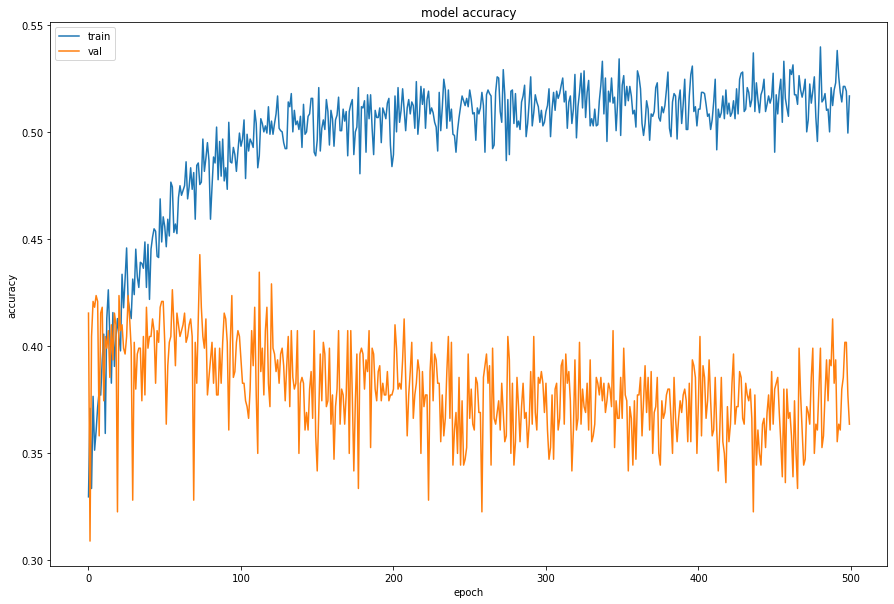

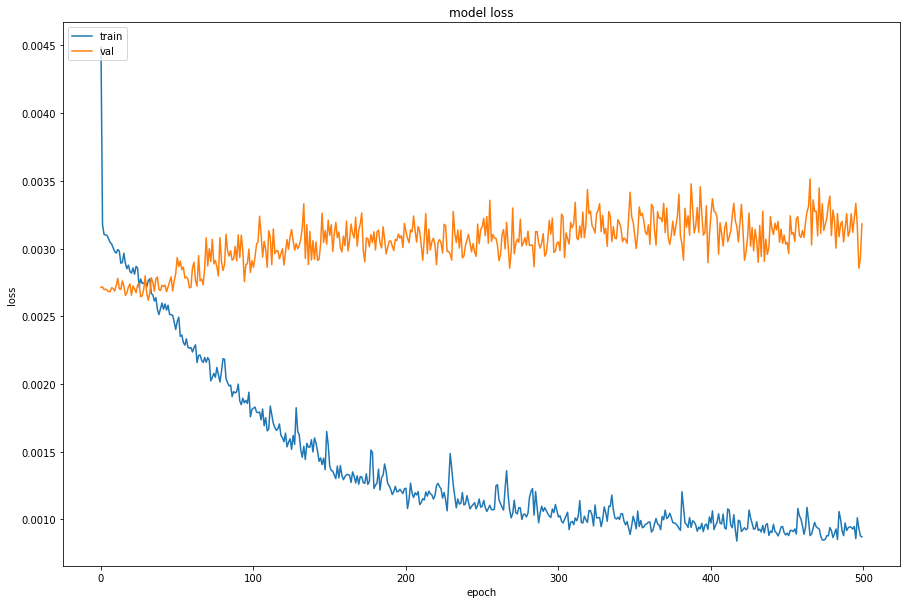

In [391]:
plt.figure(figsize=(15, 10))
plot_accuracy(history)
plt.figure(figsize=(15, 10))
plot_loss(history)


# Trains results

In [392]:
train_prediction = model.predict(X_train)


In [393]:

from sklearn.metrics import mean_absolute_error

train_mse = mean_absolute_error(y_train, train_prediction)
round(train_mse, 5)


0.01848

In [394]:
for i in range(len(labels)):
    print (labels[i],   "{:8.5f}".format(mean_absolute_error(y_train[:,i], train_prediction[:,i])))  

next1  0.01955
next2  0.01729
next3  0.01861


In [395]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_train)):
        if abs(train_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_train[i, j]) == np.sign(train_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]


next1 0.742
next2 0.854
next3 0.883


'next3'

<AxesSubplot:ylabel='Count'>

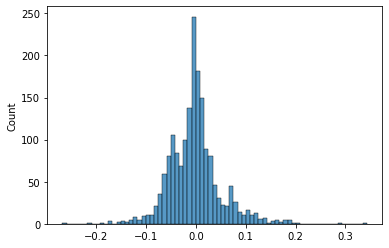

In [396]:
import seaborn as sns

sns.histplot(data=train_prediction[:, 2])


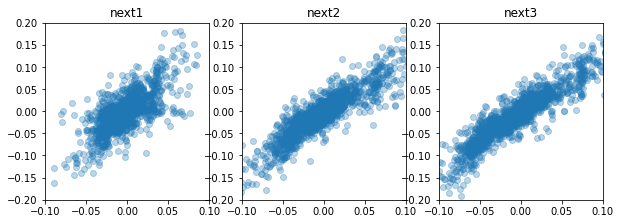

In [397]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])

    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(train_prediction[:, i], y_train[:, i], alpha=0.3)


# Test results

In [398]:
test_prediction=model.predict(X_test)

In [399]:
from sklearn.metrics import mean_absolute_error

test_mse = mean_absolute_error(y_test, test_prediction)
round(train_mse,5)

0.01848

In [400]:
for i in range(len(labels)):
    print (labels[i],   "{:8.5f}".format(mean_absolute_error(y_test[:,i], test_prediction[:,i])))  

next1  0.02682
next2  0.03916
next3  0.05033


In [401]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_test)):
        if abs(test_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_test[i, j]) == np.sign(test_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]


next1 0.555
next2 0.574
next3 0.525


'next2'

<AxesSubplot:ylabel='Count'>

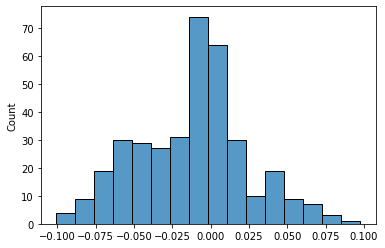

In [402]:
import seaborn as sns

sns.histplot(data=test_prediction[:, 2])


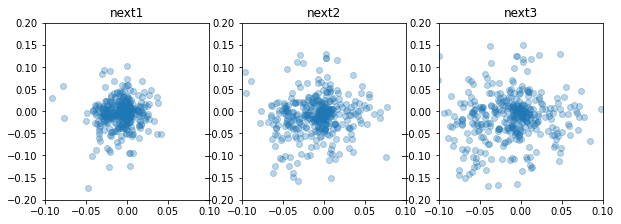

In [403]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(test_prediction[:, i], y_test[:, i], alpha=0.3)


# Backtesting

In [404]:
summer = lambda y: sum(y)/len(labels)
test_sum = np.array([summer(y) for y in test_prediction])


In [405]:
data = pd.DataFrame({'Datetime': X_test_times, 'distance': test_sum, 'Last': X_test_price })


In [406]:
def run_strategy(a_data, threshold):
    ''' Backtests the trading strategy.
    '''
    data = a_data.copy().dropna()
    data['returns'] = np.log(data['Last'] / data['Last'].shift(1)).dropna()
    # buy BTC signals
    data['position'] = np.where(data['distance'] > threshold, 1, np.nan)
    # sell BTC signals
    data['position'] = np.where(data['distance'] < -threshold, -1,
                                data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    data['strategy'] = data['position'].shift(1) * data['returns']
    # determine when a trade takes place
    trades = data['position'].diff().fillna(0) != 0
    # subtract transaction costs from return when trade takes place
    data['strategy'][trades] -= SPREAD
    data['buy'] = data['position'].diff().fillna(0) > 0
    data['sell'] = data['position'].diff().fillna(0) < 0
    data['creturns'] = INIT_DEPOSIT * data['returns'].cumsum().apply(np.exp)
    data['cstrategy'] = INIT_DEPOSIT * data['strategy'].cumsum().apply(np.exp)
    results = data
    # absolute performance of the strategy
    aperf = results['cstrategy'].iloc[-1]
    # base instrument performance (BTC)
    bperf = results['creturns'].iloc[-1]
    # out-/underperformance of strategy
    operf = aperf - bperf

    return round(aperf, 2), round(operf, 2), results

In [407]:

for i in range(100):
    x,y,z = run_strategy(data, i/100)
    print(i/100, x)    

C:\Users\Spyros\AppData\Local\Temp/ipykernel_464/809504095.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy'][trades] -= SPREAD


0.0 299.44
0.01 313.44
0.02 499.5
0.03 822.29
0.04 409.71
0.05 541.96
0.06 775.41
0.07 1562.36
0.08 196.81
0.09 196.81
0.1 1000.0
0.11 1000.0
0.12 1000.0
0.13 1000.0
0.14 1000.0
0.15 1000.0
0.16 1000.0
0.17 1000.0
0.18 1000.0
0.19 1000.0
0.2 1000.0
0.21 1000.0
0.22 1000.0
0.23 1000.0
0.24 1000.0
0.25 1000.0
0.26 1000.0
0.27 1000.0
0.28 1000.0
0.29 1000.0
0.3 1000.0
0.31 1000.0
0.32 1000.0
0.33 1000.0
0.34 1000.0
0.35 1000.0
0.36 1000.0
0.37 1000.0
0.38 1000.0
0.39 1000.0
0.4 1000.0
0.41 1000.0
0.42 1000.0
0.43 1000.0
0.44 1000.0
0.45 1000.0
0.46 1000.0
0.47 1000.0
0.48 1000.0
0.49 1000.0
0.5 1000.0
0.51 1000.0
0.52 1000.0
0.53 1000.0
0.54 1000.0
0.55 1000.0
0.56 1000.0
0.57 1000.0
0.58 1000.0
0.59 1000.0
0.6 1000.0
0.61 1000.0
0.62 1000.0
0.63 1000.0
0.64 1000.0
0.65 1000.0
0.66 1000.0
0.67 1000.0
0.68 1000.0
0.69 1000.0
0.7 1000.0
0.71 1000.0
0.72 1000.0
0.73 1000.0
0.74 1000.0
0.75 1000.0
0.76 1000.0
0.77 1000.0
0.78 1000.0
0.79 1000.0
0.8 1000.0
0.81 1000.0
0.82 1000.0
0.83 1000.0
0